# Heurística Iris Feijão com Arroz

In [502]:
# PARÂMETROS
random_seed = 42

# FEATURE SELECTION
center_stat = 'mean'

# KNN
k_min = 1
k_max = 11
distance_metric = 'euclidean'
weights = 'uniform'
split_size = 0.2

# GOURMET
palette = ['limegreen', 'indianred', 'gold']

In [503]:
import numpy
import pandas
import seaborn
from matplotlib import pyplot
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [504]:
iris_dict = load_iris()
iris_dict.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [505]:
iris = pandas.DataFrame(iris_dict['data'])
iris.columns = iris_dict['feature_names']
iris.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris['target'] = iris_dict['target']
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

iris

,sepal_length,sepal_width,petal_length,petal_width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


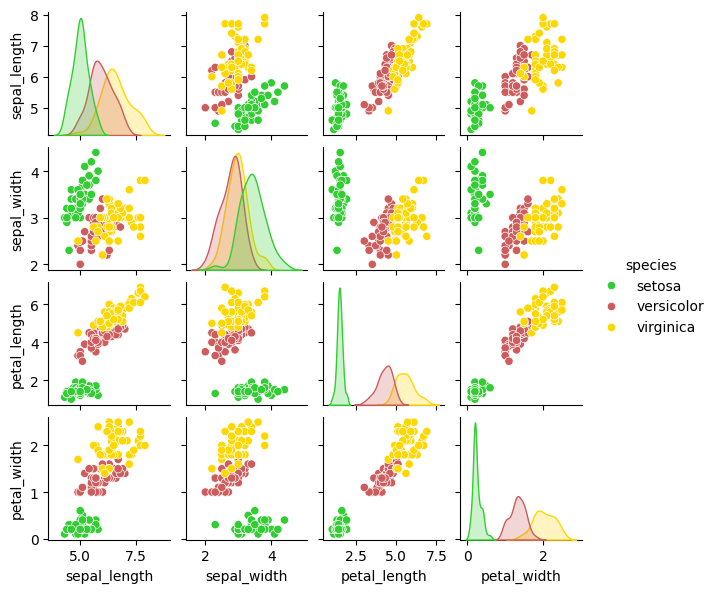

In [506]:
_ = seaborn.pairplot(iris[["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]], hue='species', palette=palette, height=1.5)

In [507]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['species'])[all_cols].agg(center_stat).T
max_diff = (centers.T.max() - centers.T.min()).sort_values(ascending=False)

max_diff

petal_length    4.090
petal_width     1.780
sepal_length    1.582
sepal_width     0.658
dtype: float64

In [508]:
max_diff.index.tolist()

['petal_length', 'petal_width', 'sepal_length', 'sepal_width']

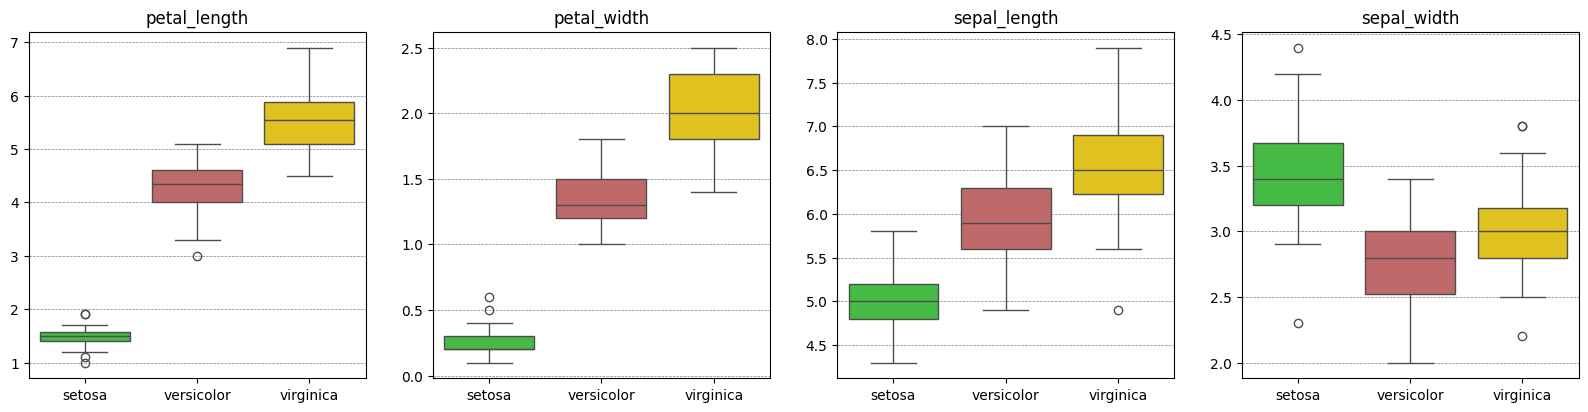

In [509]:
x_cols_sorted = max_diff.index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='species', y=x_cols_sorted[i], data=iris, ax=ax, hue='species', dodge=False, palette=palette)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

## LOOP DE TREINAMENTO FEIJÃO COM ARROZ

In [510]:
# RANDOM SEED
numpy.random.seed(random_seed)

# SEPARAR 20% DOS DADOS COMO HOLDOUT
iris_train : pandas.DataFrame = None
iris_test : pandas.DataFrame = None
iris_train, iris_test = train_test_split(iris, test_size=split_size, stratify=iris['target'], random_state=random_seed)

# LOOP DE TREINAMENTO
ks = range(k_max, k_min - 2, -2)
n_features = len(x_cols_sorted)

# STRATIFIED K-FOLD
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
skf.get_n_splits(iris_train, iris_train['target'])

# LOOP DE TREINO
# PARA TODOS OS Ks, PARA FEATURES DE 1 A 4 E PARA TODOS OS FOLDS
ix_model = 0
model_list = []
for k in ks:
    for n_feature in range(1, n_features + 1):
        ix_fold = 0
        for train_index, val_index in skf.split(iris_train, iris_train['target']):
            # SEPARAR FEATURES E TARGET
            # TREINO
            X_train = iris_train.iloc[train_index][x_cols_sorted[:n_feature]].to_numpy()
            y_train = iris_train.iloc[train_index]['target'].to_numpy()

            # VALIDAÇÃO
            X_val = iris_train.iloc[val_index][x_cols_sorted[:n_feature]].to_numpy()
            y_val = iris_train.iloc[val_index]['target'].to_numpy()

            # TESTE
            X_test = iris_test[x_cols_sorted[:n_feature]].to_numpy()
            y_test = iris_test['target'].to_numpy()

            # ESCALONAR
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)

            # TREINAR O KNN
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, weights=weights)
            knn.fit(X_train_scaled, y_train)

            # CALCULAR ACURÁCIA DE TREINO E VALIDAÇÃO
            y_train_pred = knn.predict(X_train_scaled)
            y_val_pred = knn.predict(X_val_scaled)
            train_accuracy = accuracy_score(y_train, y_train_pred)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            test_accuracy = accuracy_score(y_test, knn.predict(X_test_scaled))

            print(f"{str(ix_model).zfill(4)} > {k}/{n_feature}/{ix_fold} > treino: {100.0*train_accuracy:.1f}% | teste: {100.0*val_accuracy:.1f}%")

            model_list.append({'ix_model': ix_model,
                               'k': k,
                               'n_features': n_feature,
                               'kf' : f"{k}-{n_feature}",
                               'fold': ix_fold,
                               'stat' : 'train',
                               'accuracy': accuracy_score(y_train, y_train_pred),
                               'scaler' : scaler,
                               'knn' : knn})
            model_list.append({'ix_model': ix_model,
                               'k': k,
                               'n_features': n_feature,
                               'kf' : f"{k}-{n_feature}",
                               'fold': ix_fold,
                               'stat' : 'val',
                               'accuracy': accuracy_score(y_val, y_val_pred),
                               'scaler' : scaler,
                               'knn' : knn})
            
            model_list.append({'ix_model': ix_model,
                               'k': k,
                               'n_features': n_feature,
                               'kf' : f"{k}-{n_feature}",
                               'fold': ix_fold,
                               'stat' : 'test',
                               'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled)),
                               'scaler' : scaler,
                               'knn' : knn})
            
            ix_fold += 1
            ix_model += 1

accuracies = pandas.DataFrame(model_list)

0000 > 11/1/0 > treino: 95.8% | teste: 95.8%
0001 > 11/1/1 > treino: 95.8% | teste: 95.8%
0002 > 11/1/2 > treino: 95.8% | teste: 95.8%
0003 > 11/1/3 > treino: 95.8% | teste: 95.8%
0004 > 11/1/4 > treino: 95.8% | teste: 95.8%
0005 > 11/2/0 > treino: 96.9% | teste: 95.8%
0006 > 11/2/1 > treino: 95.8% | teste: 100.0%
0007 > 11/2/2 > treino: 96.9% | teste: 95.8%
0008 > 11/2/3 > treino: 96.9% | teste: 95.8%
0009 > 11/2/4 > treino: 96.9% | teste: 95.8%
0010 > 11/3/0 > treino: 95.8% | teste: 95.8%
0011 > 11/3/1 > treino: 94.8% | teste: 100.0%
0012 > 11/3/2 > treino: 95.8% | teste: 95.8%
0013 > 11/3/3 > treino: 96.9% | teste: 95.8%
0014 > 11/3/4 > treino: 96.9% | teste: 91.7%
0015 > 11/4/0 > treino: 95.8% | teste: 95.8%
0016 > 11/4/1 > treino: 94.8% | teste: 100.0%
0017 > 11/4/2 > treino: 94.8% | teste: 87.5%
0018 > 11/4/3 > treino: 97.9% | teste: 95.8%
0019 > 11/4/4 > treino: 95.8% | teste: 95.8%
0020 > 9/1/0 > treino: 95.8% | teste: 95.8%
0021 > 9/1/1 > treino: 95.8% | teste: 95.8%
0022 > 9/

In [511]:
accuracies

,ix_model,k,n_features,kf,fold,stat,accuracy,scaler,knn
0,0,11,1,11-1,0,train,0.958333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
1,0,11,1,11-1,0,val,0.958333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
2,0,11,1,11-1,0,test,0.933333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
3,1,11,1,11-1,1,train,0.958333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4,1,11,1,11-1,1,val,0.958333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...
355,118,1,4,1-4,3,val,0.958333,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
356,118,1,4,1-4,3,test,0.966667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
357,119,1,4,1-4,4,train,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
358,119,1,4,1-4,4,val,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."


In [512]:
mean_accuracy_by_kf = accuracies.loc[accuracies["stat"] == "val", ["k", "n_features", "kf", "accuracy"]].groupby(["k", "n_features", "kf"]).agg(["mean", "min"]).sort_values(by=['k', 'n_features'], ascending=[False, True]).reset_index()
mean_accuracy_by_kf.columns = ['k', 'f', 'kf', 'mean_accuracy', 'min_accuracy']

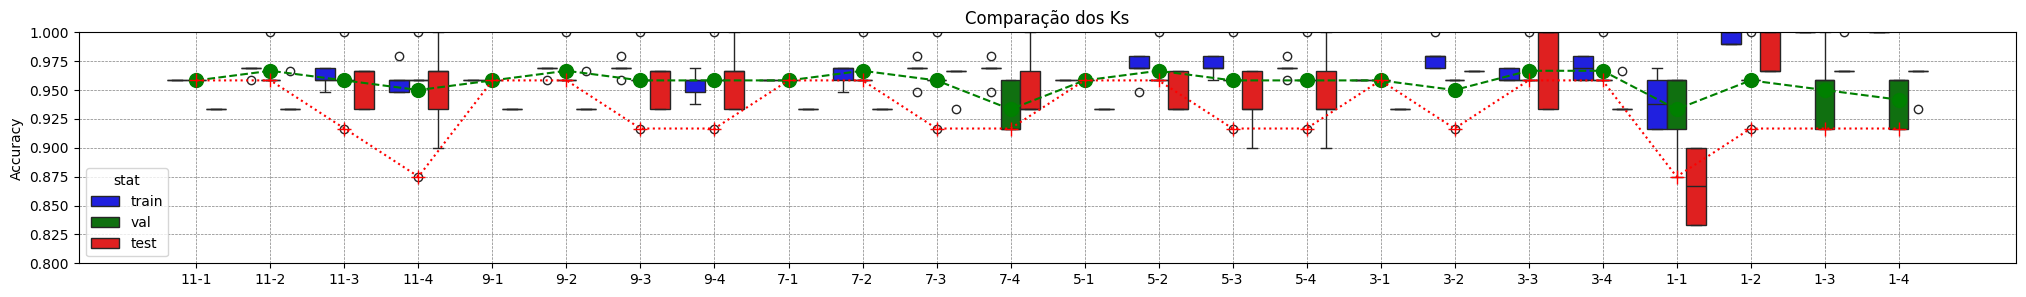

In [513]:
fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='kf', y='accuracy', data=accuracies, hue='stat', palette=['blue', 'green', 'red'], ax=ax, hue_order=['train', 'val', 'test'])
_ = ax.plot(mean_accuracy_by_kf['kf'], mean_accuracy_by_kf['mean_accuracy'], color='green', ls='--', marker='o', markersize=10, label='Média', zorder=10)
_ = ax.plot(mean_accuracy_by_kf['kf'], mean_accuracy_by_kf['min_accuracy'], color='red', ls=':', marker='+', markersize=10, label='Média', zorder=10)
ax.set_title('Comparação dos Ks')
ax.set_ylabel('Accuracy')
ax.set_xlabel('')
ax.set_ylim(0.8, 1.0)
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

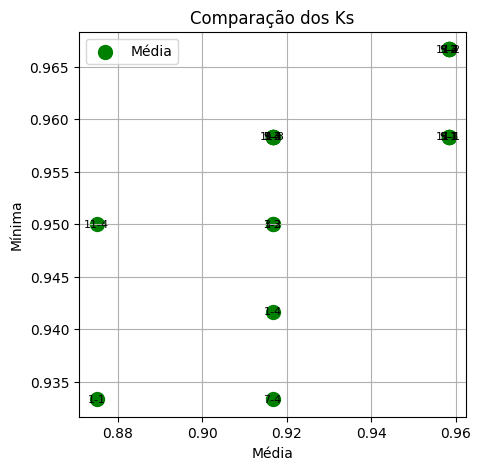

In [514]:
fig = pyplot.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
_ = mean_accuracy_by_kf.plot.scatter(x='min_accuracy', y='mean_accuracy', color='green', s=100, label='Média', ax=ax)
ax.grid()
_ = ax.set_title('Comparação dos Ks')
ax.set_xlabel('Média')
ax.set_ylabel('Mínima')
for i, txt in enumerate(mean_accuracy_by_kf['kf']):
    ax.annotate(txt, (mean_accuracy_by_kf['min_accuracy'][i], mean_accuracy_by_kf['mean_accuracy'][i]), fontsize=8, ha='center', va='center')

In [515]:
results = mean_accuracy_by_kf.sort_values(by=['min_accuracy', 'mean_accuracy', 'k', 'f'] , ascending=[False, False, False, True]).reset_index(drop=True)
results.head(5)

,k,f,kf,mean_accuracy,min_accuracy
0,11,2,11-2,0.966667,0.958333
1,9,2,9-2,0.966667,0.958333
2,7,2,7-2,0.966667,0.958333
3,5,2,5-2,0.966667,0.958333
4,3,3,3-3,0.966667,0.958333


In [516]:
winner_k = results.iloc[0]['k']
winner_f = results.iloc[0]['f']

winner_k, winner_f

(np.int64(11), np.int64(2))

In [517]:
best_fold_knn = accuracies.loc[(accuracies['k'] == winner_k) & (accuracies['n_features'] == winner_f) & (accuracies['stat'] == 'val')].sort_values("accuracy", ascending=False).iloc[0]

best_fold_scaler = best_fold_knn['scaler']
best_fold_knn = best_fold_knn['knn']

# CALCULATE HOLDOUT ACCURACY
X_test = iris_test[x_cols_sorted[:winner_f]].to_numpy()
y_test = iris_test['target'].to_numpy()
X_test_scaled = best_fold_scaler.transform(X_test)
y_test_pred = best_fold_knn.predict(X_test_scaled)

X_all = iris[x_cols_sorted[:winner_f]].to_numpy()
y_all = iris['target'].to_numpy()

X_all_scaled = best_fold_scaler.transform(X_all)
y_all_pred = best_fold_knn.predict(X_all_scaled)

print(f"Holdout accuracy: {100.0*accuracy_score(y_test, y_test_pred):.1f}%, all accuracy: {100.0*accuracy_score(y_all, y_all_pred):.1f}%")

Holdout accuracy: 93.3%, all accuracy: 96.0%


### RETREINO DO MELHOR HIPERPARAMETRO

In [ ]:
X_train_final = iris_train.iloc[:, :winner_f].to_numpy()
y_train_final = iris_train['target'].to_numpy()
X_test_final = iris_test.iloc[:, :winner_f].to_numpy()
y_test_final = iris_test['target'].to_numpy()
X_all_final = iris[x_cols_sorted[:winner_f]].to_numpy()

# ESCALONAR
scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)
X_all_final_scaled = scaler.transform(X_all_final)

# TREINAR O KNN
knn = KNeighborsClassifier(n_neighbors=winner_k, metric=distance_metric, weights=weights)
knn.fit(X_train_final_scaled, y_train_final)

# CALCULAR ACURACIA DE TREINO E HOLDOUT
y_train_final_pred = knn.predict(X_train_final_scaled)
y_test_final_pred = knn.predict(X_test_final_scaled)

train_accuracy_final = accuracy_score(y_train_final, y_train_final_pred)
val_accuracy_final = accuracy_score(y_test_final, y_test_final_pred)
print(f"Treino: {100.0*train_accuracy_final:.1f}% | Teste: {100.0*val_accuracy_final:.1f}%")

Treino: 82.5% | Teste: 76.7%
